In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import nibabel
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from skimage.filters import unsharp_mask
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from skimage.transform import resize
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric
from dipy.align.imaffine import AffineMap
from dipy.align import resample
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Dense, Flatten
from tensorflow.keras.layers import Conv3D, AveragePooling3D, MaxPooling3D
from tensorflow.keras.layers import add, multiply, GlobalAveragePooling3D, GlobalMaxPooling3D, Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback

/home/uiu/miniconda3/envs/tf_conda/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import six
from math import ceil

In [5]:
def _bn_relu(input):
    """Helper to build a BN -> relu block (by @raghakot)."""
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)

def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        conv = Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer,
        )(input)
        return _bn_relu(conv)

    return f

In [6]:
def _bn_relu_conv3d(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer,
        )(activation)

    return f

def _shortcut3d(input, residual):
    stride_dim1 = ceil(input.shape[DIM1_AXIS] / residual.shape[DIM1_AXIS])
    stride_dim2 = ceil(input.shape[DIM2_AXIS] / residual.shape[DIM2_AXIS])
    stride_dim3 = ceil(input.shape[DIM3_AXIS] / residual.shape[DIM3_AXIS])
    equal_channels = residual.shape[CHANNEL_AXIS] == input.shape[CHANNEL_AXIS]

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 or not equal_channels:
        shortcut = Conv3D(
            filters=residual.shape[CHANNEL_AXIS],
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            kernel_initializer="he_normal",
            padding="valid",
            kernel_regularizer=l2(1e-4),
        )(input)
    return add([shortcut, residual])

In [7]:
def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        conv = Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer,
        )(input)
        return _bn_relu(conv)

    return f

def _bn_relu_conv3d(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer,
        )(activation)

    return f

In [8]:
def _shortcut3d(input, residual):
    stride_dim1 = ceil(input.shape[DIM1_AXIS] / residual.shape[DIM1_AXIS])
    stride_dim2 = ceil(input.shape[DIM2_AXIS] / residual.shape[DIM2_AXIS])
    stride_dim3 = ceil(input.shape[DIM3_AXIS] / residual.shape[DIM3_AXIS])
    equal_channels = residual.shape[CHANNEL_AXIS] == input.shape[CHANNEL_AXIS]

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 or not equal_channels:
        shortcut = Conv3D(
            filters=residual.shape[CHANNEL_AXIS],
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            kernel_initializer="he_normal",
            padding="valid",
            kernel_regularizer=l2(1e-4),
        )(input)
    return add([shortcut, residual])

def _residual_block_with_cbam(
    filters,
    kernel_regularizer,
    is_first_layer=False,
):
    def f(input):
        strides = (2, 2, 2) if not is_first_layer else (1, 1, 1)
        conv1 = _conv_bn_relu3D(
            filters=filters,
            kernel_size=(5, 5, 5),  # Changed kernel size
            strides=strides,
            kernel_regularizer=kernel_regularizer,
        )(input)
        
        conv2 = _conv_bn_relu3D(
            filters=filters,
            kernel_size=(5, 5, 5),  # Changed kernel size
            kernel_regularizer=kernel_regularizer,
        )(conv1)

        # CBAM module
        channel_avg_pool = GlobalAveragePooling3D()(conv2)
        channel_max_pool = GlobalMaxPooling3D()(conv2)
        channel_attention = add([Dense(filters // 2, activation='relu')(channel_avg_pool),
                                 Dense(filters // 2, activation='relu')(channel_max_pool)])
        channel_attention = Activation('sigmoid')(Dense(filters, activation='relu')(channel_attention))
        channel_attention = Reshape((1, 1, 1, filters))(channel_attention)
        channel_attention = multiply([conv2, channel_attention])

        spatial_attention = Conv3D(1, (1, 1, 1), activation='sigmoid', padding='same', kernel_initializer='he_normal')(conv2)
        attention = multiply([conv2, spatial_attention])

        conv2 = add([channel_attention, attention])
        
        return _shortcut3d(input, conv2)

    return f

In [9]:
def basic_block(
    filters,
    strides=(1, 1, 1),
    kernel_regularizer=l2(1e-4),
    is_first_block_of_first_layer=False,
):
    def f(input):
        if is_first_block_of_first_layer:
            conv1 = Conv3D(
                filters=filters,
                kernel_size=(5, 5, 5),  # Changed kernel size
                strides=strides,
                padding="same",
                kernel_initializer="he_normal",
                kernel_regularizer=kernel_regularizer,
            )(input)
        else:
            conv1 = _bn_relu_conv3d(
                filters=filters,
                kernel_size=(5, 5, 5),  # Changed kernel size
                strides=strides,
                kernel_regularizer=kernel_regularizer,
            )(input)

        residual = _bn_relu_conv3d(
            filters=filters,
            kernel_size=(5, 5, 5),  # Changed kernel size
            kernel_regularizer=kernel_regularizer,
        )(conv1)
        return _shortcut3d(input, residual)

    return f

def _handle_data_format():
    global DIM1_AXIS
    global DIM2_AXIS
    global DIM3_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == "channels_last":
        DIM1_AXIS = 1
        DIM2_AXIS = 2
        DIM3_AXIS = 3
        CHANNEL_AXIS = 4
    else:
        CHANNEL_AXIS = 1
        DIM1_AXIS = 2
        DIM2_AXIS = 3
        DIM3_AXIS = 4

def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError("Invalid {}".format(identifier))
        return res
    return identifier

class Resnet3DBuilder(object):
    """ResNet3D."""

    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions, reg_factor):
        """Instantiate a vanilla ResNet3D keras model.

        # Arguments
            input_shape: Tuple of input shape in the format
            (conv_dim1, conv_dim2, conv_dim3, channels) if dim_ordering='tf'
            (filter, conv_dim1, conv_dim2, conv_dim3) if dim_ordering='th'
            num_outputs: The number of outputs at the final softmax layer
            block_fn: Unit block to use {'basic_block', 'bottlenack_block'}
            repetitions: Repetitions of unit blocks
        # Returns
            model: a 3D ResNet model that takes a 5D tensor (volumetric images
            in batch) as input and returns a 1D vector (prediction) as output.
        """
        _handle_data_format()
        if len(input_shape) != 4:
            raise ValueError(
                "Input shape should be a tuple "
                "(conv_dim1, conv_dim2, conv_dim3, channels) "
                "for tensorflow as backend or "
                "(channels, conv_dim1, conv_dim2, conv_dim3) "
                "for theano as backend"
            )

        block_fn = _get_block(block_fn)
        input = Input(shape=input_shape)
        # first conv
        conv1 = _conv_bn_relu3D(
            filters=128,  # Changed filter size
            kernel_size=(5, 5, 5),  # Changed kernel size
            strides=(2, 2, 2),
            kernel_regularizer=l2(reg_factor),
        )(input)
        pool1 = MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 2), padding="same")(
            conv1
        )

        # repeat blocks
        block = pool1
        filters = 128  # Changed filter size
        for i, r in enumerate(repetitions):
            block = _residual_block_with_cbam(
                filters=filters,
                kernel_regularizer=l2(reg_factor),
                is_first_layer=(i == 0),
            )(block)
            filters *= 2

        # last activation
        block_output = _bn_relu(block)

        # average pool and classification
        pool2 = AveragePooling3D(
            pool_size=(
                block.shape[DIM1_AXIS],
                block.shape[DIM2_AXIS],
                block.shape[DIM3_AXIS],
            ),
            strides=(1, 1, 1),
        )(block_output)
        flatten1 = Flatten()(pool2)
        if num_outputs > 1:
            dense = Dense(
                units=num_outputs,
                kernel_initializer="he_normal",
                activation="softmax",
                kernel_regularizer=l2(reg_factor),
            )(flatten1)
        else:
            dense = Dense(
                units=num_outputs,
                kernel_initializer="he_normal",
                activation="sigmoid",
                kernel_regularizer=l2(reg_factor),
            )(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 18."""
        return Resnet3DBuilder.build(
            input_shape, num_outputs, basic_block, [2, 2, 2, 2], reg_factor=reg_factor
        )
    @staticmethod
    def build_resnet_34(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 34."""
        return Resnet3DBuilder.build(
            input_shape, num_outputs, basic_block, [3, 4, 6, 3], reg_factor=reg_factor
        )

    @staticmethod
    def build_resnet_50(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 50."""
        return Resnet3DBuilder.build(
            input_shape, num_outputs, basic_block, [3, 4, 6, 3], reg_factor=reg_factor
        )

    @staticmethod
    def build_resnet_101(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 101."""
        return Resnet3DBuilder.build(
            input_shape, num_outputs, basic_block, [3, 4, 23, 3], reg_factor=reg_factor
        )

    @staticmethod
    def build_resnet_152(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 152."""
        return Resnet3DBuilder.build(
            input_shape, num_outputs, basic_block, [3, 16, 36, 6], reg_factor=reg_factor
        )


In [10]:
# Testing the model
def apply_mask(aseg_image, brain_image, labels = [17, 53, 2, 7, 41, 46]):
    brain_data = aseg_image.get_fdata()
    aseg_data = aseg_image.get_fdata()
    origin_data = brain_image.get_fdata()
    
    brain_mask = np.zeros_like(aseg_data)
    for label in labels:
        brain_mask += np.where((aseg_data == label), 1, 0)

    new_image = origin_data * brain_mask
    
    return new_image

In [11]:
def enhance_slice(slice_data):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_slice = clahe.apply(slice_data.astype(np.uint8))

    return enhanced_slice

def enhance_image(img_data):
    enhanced_image = np.zeros_like(img_data)
    for i in range(img_data.shape[2]):
        enhanced_image[:, :, i] = enhance_slice(img_data[:, :, i])
    return enhanced_image


In [12]:
def sharpen_image(image, strength=1.0):
    sharpened_image = unsharp_mask(image, radius=1, amount=strength)
    return sharpened_image

def apply_nonlinear_registration(moving_image, fixed_image):
    metric = CCMetric(3)

    sdr = SymmetricDiffeomorphicRegistration(metric, [10, 10, 10], step_length=0.25, ss_sigma_factor=1.5)

    mapping = sdr.optimize(fixed_image, moving_image)

    warped_moving_image = mapping.transform(moving_image)

    return warped_moving_image


In [13]:
def image_fixed(image_type, target_shape):
    aseg_image = nibabel.load('/home/uiu/Project/adni-1-5t-filtered-preprocessed-quickseg-dataset/AD/I65597.nii')
    base_path = "/home/uiu/Project/adni-1-5t-filtered-preprocessed-quickseg-dataset/AD/I65597.nii/mri/orig.mgz"
    origin_image =  nibabel.load(base_path)
    
    if (image_type == 'roi') :
        image = apply_mask(aseg_image, origin_image)
        image = resize(image, target_shape, anti_aliasing=True)
        image = sharpen_image(image)
        return image


In [14]:
from scipy.ndimage import rotate


In [15]:
def augment(image, rotation_range):
    rotation_angle = np.random.uniform(-rotation_range, rotation_range)
    rotated_image = rotate(image, rotation_angle, reshape=False)
    
    return rotated_image



def image_loader_roi(image_path, target_shape, type_dt=''):
    aseg_image = nibabel.load(image_path)
    base_path = "/".join(image_path.split('/')[:-1]) + "/orig.mgz"
    base_image =  nibabel.load(base_path)
    
    image = apply_mask(aseg_image, base_image)
    image = resize(image, target_shape, anti_aliasing=True)
    image = enhance_image(image)
    image = sharpen_image(image)
    
    if type_dt=='train':
        image = augment(image, 50)

    return image

In [16]:
def data_generator(paths, labels, batch_size, target_shape, image_type, type_dt=''):
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            batch_images = []
            
    
            if image_type == 'roi':
                batch_images = [image_loader_roi(image, target_shape, type_dt) for image in batch_paths]


            batch_images = np.stack([batch_images] * 1, axis=-1)

            batch_labels = to_categorical(batch_labels, num_classes=2)
            yield np.array(batch_images), batch_labels
base_dir = '/home/uiu/Project/adni-1-5t-filtered-preprocessed-quickseg-dataset'
ad = os.path.join(base_dir, 'AD')
mci = os.path.join(base_dir, 'MCI')
cn = os.path.join(base_dir, 'CN')
# original shape (257, 257, 257)

ad_images= []
mci_images = []
cn_images = []

for subject_dir in os.listdir(ad):
    mri_path = os.path.join(ad, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    if not (len(os.listdir(os.path.join(ad, subject_dir, 'mri'))) < 6):
        ad_images.append(mri_path)
        
for subject_dir in os.listdir(mci):
    mri_path = os.path.join(mci, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    
    if not (len(os.listdir(os.path.join(mci, subject_dir, 'mri'))) < 6):
        mci_images.append(mri_path)
        
for subject_dir in os.listdir(cn):
    mri_path = os.path.join(cn, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    if not (len(os.listdir(os.path.join(cn, subject_dir, 'mri'))) < 6):
        cn_images.append(mri_path)


image_path = mci_images + cn_images + cn_images[:len(mci_images)-len(cn_images)]
labels = [0] * len(mci_images) + [1] * len(cn_images) + [1] * len(cn_images[:len(mci_images)-len(cn_images)])
train_paths, test_paths, train_labels, test_labels = train_test_split(image_path, labels, test_size = 0.2, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)
test_paths = np.array(test_paths)
test_labels = np.array(test_labels)

train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)
test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)

target_shape = (100, 100, 100)
batch_size = 10
selection_type = 'roi'
train_dataset = data_generator(train_paths, train_labels, batch_size, target_shape, 
                               image_type=selection_type, 
                               type_dt='train'
                              )

test_dataset = data_generator(test_paths, test_labels, batch_size, target_shape, 
                              image_type=selection_type
                             )
len(test_paths), len(train_labels), class_weights


(127, 505, array([1.03909465, 0.96374046]))

In [17]:
from tensorflow.keras.optimizers import Adam

In [18]:
classes = 2
image_shape = (*target_shape, 1)
model = Resnet3DBuilder.build_resnet_152(input_shape = image_shape, num_outputs=classes)

model.compile(
    optimizer=Adam(0.00001), 
    loss='binary_crossentropy', 
    metrics=['accuracy', 'Recall', 'AUC', 'Precision'] 
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 10 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 50, 50, 50, 1 16128       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 50, 50, 50, 1 512         conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 50, 50, 50, 1 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
num_epoch = 100
history = model.fit(
    train_dataset,
    epochs = num_epoch,
    steps_per_epoch = len(train_paths) // batch_size,
    validation_data = test_dataset,
    validation_steps= len(test_paths) // batch_size,
    
)

KeyboardInterrupt: 

In [ ]:
model.save("UpgradedFilter_ROI_IJK_100_Epoch_v2.h5")

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('UpgradedFilter_ROI_IJK_100_Epoch_v2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("UpgradedFilter_ROI_IJK_100_Epoch_v2.png")

plt.tight_layout()
plt.show()

In [21]:
from tensorflow.keras.models import load_model

model = load_model('UpgradedFilter_ROI_IJK_100_Epoch_v3.h5')


In [ ]:
model.compile(
    optimizer=Adam(0.00001), 
    loss='binary_crossentropy', 
    metrics=['accuracy', 'Recall', 'AUC', 'Precision'] 
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
#No
model_checkpoint = ModelCheckpoint('UpgradedFilter_ROI_IJK_100_Epoch_v2.h5', monitor='val_accuracy', mode='max', save_best_only=True)

num_epoch = 20
history = model.fit(
    train_dataset,
    epochs=num_epoch,
    steps_per_epoch=len(train_paths) // batch_size,
    validation_data=test_dataset,
    validation_steps=len(test_paths) // batch_size,
    callbacks=[model_checkpoint]  
)


In [ ]:
# NO

saved_model = tf.keras.models.load_model('UpgradedFilter_ROI_IJK_100_Epoch_v2.h5')
test_accuracy = saved_model.evaluate(
    test_dataset,
    steps=len(test_paths) // batch_size,
    verbose=1
)
print("Test Accuracy:", test_accuracy)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

num_epoch = 4
best_val_accuracy = 0.0
model_checkpoint_path = 'UpgradedFilter_ROI_IJK_100_Epoch_v3.h5'

for epoch in range(num_epoch):
    print("Epoch {}/{}".format(epoch + 1, num_epoch))

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=1,  
        steps_per_epoch=len(train_paths) // batch_size,
        validation_data=test_dataset,
        validation_steps=len(test_paths) // batch_size,
        verbose=1 
    )

    # Evaluate the model on validation data
    val_accuracy = history.history['val_accuracy'][0]

    # Save the model if validation accuracy improved
    if val_accuracy > best_val_accuracy:
        print("Validation accuracy improved from {} to {}. Saving model...".format(best_val_accuracy, val_accuracy))
        best_val_accuracy = val_accuracy
        model.save(model_checkpoint_path)
    else:
        print("Validation accuracy did not improve. Model not saved.")

    print("")




In [22]:
# Load the best model and evaluate on test data
saved_model = tf.keras.models.load_model('Best_Test_Accuracy_Model.h5')
test_accuracy = saved_model.evaluate(
    test_dataset,
    steps=len(test_paths) // batch_size,
    verbose=1
)
print("Test Accuracy:", test_accuracy)

12/12 [==============================] - 105s 9s/step - loss: 1.1408 - accuracy: 0.9167 - recall: 0.9167 - auc: 0.9397 - precision: 0.9167
Test Accuracy: [1.14083731174469, 0.9166666865348816, 0.9166666865348816, 0.9396527409553528, 0.9166666865348816]


In [16]:
def data_generator(paths, labels, batch_size, target_shape, image_type, type_dt=''):
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            batch_images = []
            
    
            if image_type == 'roi':
                batch_images = [image_loader_roi(image, target_shape, type_dt) for image in batch_paths]


            batch_images = np.stack([batch_images] * 1, axis=-1)

            batch_labels = to_categorical(batch_labels, num_classes=2)
            yield np.array(batch_images), batch_labels
base_dir = '/home/uiu/Project/adni-1-5t-filtered-preprocessed-quickseg-dataset'
ad = os.path.join(base_dir, 'AD')
mci = os.path.join(base_dir, 'MCI')
cn = os.path.join(base_dir, 'CN')
# original shape (257, 257, 257)

ad_images= []
mci_images = []
cn_images = []

for subject_dir in os.listdir(ad):
    mri_path = os.path.join(ad, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    if not (len(os.listdir(os.path.join(ad, subject_dir, 'mri'))) < 6):
        ad_images.append(mri_path)
        
for subject_dir in os.listdir(mci):
    mri_path = os.path.join(mci, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    
    if not (len(os.listdir(os.path.join(mci, subject_dir, 'mri'))) < 6):
        mci_images.append(mri_path)
        
for subject_dir in os.listdir(cn):
    mri_path = os.path.join(cn, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    if not (len(os.listdir(os.path.join(cn, subject_dir, 'mri'))) < 6):
        cn_images.append(mri_path)
        



image_path = mci_images + cn_images + cn_images[:len(mci_images)-len(cn_images)]
labels = [0] * len(mci_images) + [1] * len(cn_images) + [1] * len(cn_images[:len(mci_images)-len(cn_images)])
len(image_path), len(labels), len(mci_images), len(cn_images + cn_images[:len(mci_images)-len(cn_images)])
train_paths, test_paths, train_labels, test_labels = train_test_split(image_path, labels, test_size=0.2, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.125, random_state=42)


class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
len(train_paths), len(val_paths), len(test_paths), np.unique(train_labels)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)
val_paths = np.array(val_paths)
val_labels = np.array(val_labels)
test_paths = np.array(test_paths)
test_labels = np.array(test_labels)

train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)
val_paths, val_labels = shuffle(val_paths, val_labels, random_state=42)
test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)
target_shape = (100, 100, 100)
batch_size = 10
selection_type = 'roi'
train_dataset = data_generator(train_paths, train_labels, batch_size, target_shape, 
                               image_type=selection_type, 
                               type_dt='train'
                              )
val_dataset = data_generator(val_paths, val_labels, batch_size, target_shape, 
                             image_type=selection_type)
test_dataset = data_generator(test_paths, test_labels, batch_size, target_shape, 
                              image_type=selection_type
                             )
len(train_paths), len(val_paths), len(test_paths), len(train_labels), class_weights


(441, 64, 127, 441, array([1.02083333, 0.98      ]))

In [19]:
from tensorflow.keras.models import load_model

model = load_model('UpgradedFilter_ROI_IJK_100_Epoch_v4.h5')


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint('UpgradedFilter_ROI_IJK_100_Epoch_v5.h5', monitor='val_accuracy', mode='max', save_best_only=True)

num_epoch = 100
best_test_accuracy = 0.0

for epoch in range(num_epoch):
    print("Epoch {}/{}".format(epoch + 1, num_epoch))

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=1,
        steps_per_epoch=len(train_paths) // batch_size,
        validation_data=val_dataset,
        validation_steps=len(val_paths) // batch_size,
        verbose=1
    )

    # Evaluate the model on test data
    test_metrics = model.evaluate(
        test_dataset,
        steps=len(test_paths) // batch_size,
        verbose=0
    )
    test_accuracy = test_metrics[1]


    if test_accuracy > best_test_accuracy:
        print("Test accuracy improved from {:.4f} to {:.4f}. Saving model.".format(best_test_accuracy, test_accuracy))
        best_test_accuracy = test_accuracy
        model.save('Best_Test_Accuracy_Model.h5')


    print("Test Accuracy: {:.4f}".format(test_accuracy))
    print("")


Epoch 1/100
44/44 [==============================] - 501s 12s/step - loss: 0.9235 - accuracy: 0.9652 - recall: 0.9652 - auc: 0.9920 - precision: 0.9652 - val_loss: 0.9601 - val_accuracy: 0.9167 - val_recall: 0.9167 - val_auc: 0.9881 - val_precision: 0.9167
Test accuracy improved from 0.0000 to 0.8417. Saving model.
Test Accuracy: 0.8417

Epoch 2/100
44/44 [==============================] - 502s 12s/step - loss: 0.8914 - accuracy: 0.9907 - recall: 0.9907 - auc: 0.9943 - precision: 0.9907 - val_loss: 1.0990 - val_accuracy: 0.9000 - val_recall: 0.9000 - val_auc: 0.9369 - val_precision: 0.9000
Test Accuracy: 0.7917

Epoch 3/100
44/44 [==============================] - 502s 12s/step - loss: 0.8847 - accuracy: 0.9838 - recall: 0.9838 - auc: 0.9965 - precision: 0.9838 - val_loss: 1.7554 - val_accuracy: 0.7167 - val_recall: 0.7167 - val_auc: 0.7811 - val_precision: 0.7167
Test Accuracy: 0.4917

Epoch 4/100
44/44 [==============================] - 502s 12s/step - loss: 0.9693 - accuracy: 0.9490

Test Accuracy: 0.7667

Epoch 30/100
44/44 [==============================] - 495s 11s/step - loss: 0.8280 - accuracy: 0.9884 - recall: 0.9884 - auc: 0.9972 - precision: 0.9884 - val_loss: 1.0058 - val_accuracy: 0.9500 - val_recall: 0.9500 - val_auc: 0.9728 - val_precision: 0.9500
Test Accuracy: 0.8417

Epoch 31/100
44/44 [==============================] - 493s 11s/step - loss: 0.8389 - accuracy: 0.9884 - recall: 0.9884 - auc: 0.9946 - precision: 0.9884 - val_loss: 0.9350 - val_accuracy: 0.9333 - val_recall: 0.9333 - val_auc: 0.9769 - val_precision: 0.9333
Test Accuracy: 0.8083

Epoch 32/100
44/44 [==============================] - 488s 11s/step - loss: 0.8228 - accuracy: 0.9884 - recall: 0.9884 - auc: 0.9972 - precision: 0.9884 - val_loss: 0.9262 - val_accuracy: 0.9167 - val_recall: 0.9167 - val_auc: 0.9892 - val_precision: 0.9167
Test Accuracy: 0.8500

Epoch 33/100
44/44 [==============================] - 489s 11s/step - loss: 0.8143 - accuracy: 0.9930 - recall: 0.9930 - auc: 0.9997 -

In [17]:
from tensorflow.keras.models import load_model

model = load_model('Best_Test_Accuracy_Model.h5')


In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint('Best_Test_Accuracy_Model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

num_epoch = 50
best_test_accuracy = 0.0

for epoch in range(num_epoch):
    print("Epoch {}/{}".format(epoch + 1, num_epoch))

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=1,
        steps_per_epoch=len(train_paths) // batch_size,
        validation_data=val_dataset,
        validation_steps=len(val_paths) // batch_size,
        verbose=1
    )

    # Evaluate the model on test data
    test_metrics = model.evaluate(
        test_dataset,
        steps=len(test_paths) // batch_size,
        verbose=0
    )
    test_accuracy = test_metrics[1]


    if test_accuracy > best_test_accuracy:
        print("Test accuracy improved from {:.4f} to {:.4f}. Saving model.".format(best_test_accuracy, test_accuracy))
        best_test_accuracy = test_accuracy
        model.save('Best_Test_Accuracy_Model_v2.h5')


    print("Test Accuracy: {:.4f}".format(test_accuracy))
    print("")


Epoch 1/50
44/44 [==============================] - 514s 12s/step - loss: 0.8993 - accuracy: 0.9773 - recall: 0.9773 - auc: 0.9956 - precision: 0.9773 - val_loss: 1.1124 - val_accuracy: 0.8833 - val_recall: 0.8833 - val_auc: 0.9244 - val_precision: 0.8833
Test accuracy improved from 0.0000 to 0.8833. Saving model.
Test Accuracy: 0.8833

Epoch 2/50
44/44 [==============================] - 511s 12s/step - loss: 0.8507 - accuracy: 0.9886 - recall: 0.9886 - auc: 0.9998 - precision: 0.9886 - val_loss: 0.9094 - val_accuracy: 0.9667 - val_recall: 0.9667 - val_auc: 0.9939 - val_precision: 0.9667
Test Accuracy: 0.8333

Epoch 3/50
44/44 [==============================] - 511s 12s/step - loss: 0.8611 - accuracy: 0.9886 - recall: 0.9886 - auc: 0.9968 - precision: 0.9886 - val_loss: 1.2360 - val_accuracy: 0.8500 - val_recall: 0.8500 - val_auc: 0.9019 - val_precision: 0.8500
Test Accuracy: 0.8667

Epoch 4/50
44/44 [==============================] - 507s 12s/step - loss: 0.8862 - accuracy: 0.9727 - r

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

num_epoch = 4
best_val_accuracy = 0.0
model_checkpoint_path = 'UpgradedFilter_ROI_IJK_100_Epoch_v4.h5'

for epoch in range(num_epoch):
    print("Epoch {}/{}".format(epoch + 1, num_epoch))

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=1,  
        steps_per_epoch=len(train_paths) // batch_size,
        validation_data=val_dataset,
        validation_steps=len(val_paths) // batch_size,
        verbose=1 
    )

    # Evaluate the model on validation data
    val_accuracy = history.history['val_accuracy'][0]

    # Evaluate the model on test data
    test_metrics = model.evaluate(
        test_dataset,
        steps=len(test_paths) // batch_size,
        verbose=0
    )
    test_accuracy = test_metrics[1]

    # Save the model if validation accuracy improved
    if val_accuracy > best_val_accuracy:
        print("Validation accuracy improved from {} to {}. Saving model...".format(best_val_accuracy, val_accuracy))
        best_val_accuracy = val_accuracy
        model.save(model_checkpoint_path)
    else:
        print("Validation accuracy did not improve. Model not saved.")
    
    # Print test metrics
    print("Test Accuracy: {:.4f}".format(test_accuracy))

    print("")


Epoch 1/4
44/44 [==============================] - 514s 12s/step - loss: 1.0093 - accuracy: 0.9432 - recall: 0.9432 - auc: 0.9748 - precision: 0.9432 - val_loss: 0.9774 - val_accuracy: 0.9667 - val_recall: 0.9667 - val_auc: 0.9928 - val_precision: 0.9667
Validation accuracy improved from 0.0 to 0.9666666388511658. Saving model...
Test Accuracy: 0.8833

Epoch 2/4
44/44 [==============================] - 515s 12s/step - loss: 1.0205 - accuracy: 0.9409 - recall: 0.9409 - auc: 0.9740 - precision: 0.9409 - val_loss: 0.9421 - val_accuracy: 0.9833 - val_recall: 0.9833 - val_auc: 0.9981 - val_precision: 0.9833
Validation accuracy improved from 0.9666666388511658 to 0.9833333492279053. Saving model...
Test Accuracy: 0.8333

Epoch 3/4
44/44 [==============================] - 512s 12s/step - loss: 0.9743 - accuracy: 0.9386 - recall: 0.9386 - auc: 0.9875 - precision: 0.9386 - val_loss: 1.0788 - val_accuracy: 0.9000 - val_recall: 0.9000 - val_auc: 0.9692 - val_precision: 0.9000
Validation accuracy 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [20]:

# Load the saved model
saved_model = tf.keras.models.load_model('Best_Test_Accuracy_Model.h5')

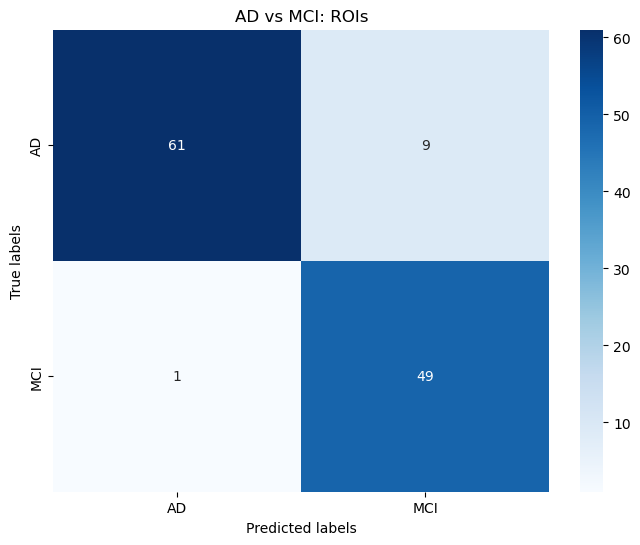

In [21]:

predictions = saved_model.predict(test_dataset, steps=len(test_paths) // batch_size)
predicted_labels = np.argmax(predictions, axis=1)


conf_matrix = confusion_matrix(test_labels[:len(predicted_labels)], predicted_labels)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['AD', 'MCI'], yticklabels=['AD', 'MCI'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('AD vs MCI: ROIs')
plt.savefig('confusion_matrix_6roi_ADvsMCI.png')


plt.show()
